<div align="center"><font size="6">Freeze-Non freeze Products Classifier</font></div>

# 1. The Precios Cuidados Dataset

### Imports

In [1]:
from sklearn.datasets import load_files
from random import randint,shuffle
import matplotlib.pyplot as plt 
import numpy as np
import cv2
import PIL.Image
import h5py
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array,array_to_img
from keras.utils import to_categorical

Using TensorFlow backend.


### Loading the Dataset

In [2]:
# Read the product images from the directory
data_dir  = "../data/preciosclaros_products"
bottleneck_features_dir = "../bottleneck_features"

print("Loading dataset from: ", data_dir,"\n")
raw_data = load_files(data_dir)

Loading dataset from:  ../data/preciosclaros_products 



### Exploring the Dataset

In [3]:
# Sklearn packged the images in a dictionary
print("Dataset keys: ",raw_data.keys())

# Reading the information form the sklearn dataset
filenames = raw_data['filenames']
target_classes = raw_data['target']
target_names = raw_data['target_names']
data = raw_data['data']

raw_img_qty = len(filenames)

print("Dataset images qty:", raw_img_qty)
print("Classes qty:", len(target_names))
print("Classes names:", target_names)
print("\n")

print("# Products of each class:")
for c in range(len(target_names)):
    prod_qty = len([p for p in target_classes if p==c])
    print("{}: {} ({}%)".format(str(c)+": "+target_names[c], prod_qty, round(prod_qty/raw_img_qty,2)))
    
raw_img_idx = randint(1,raw_img_qty)
filename = filenames[raw_img_idx]   
img = cv2.imread(filename)

print("\n")
print("Each image shape: ",img.shape)





Dataset keys:  dict_keys(['target_names', 'target', 'filenames', 'data', 'DESCR'])
Dataset images qty: 4685
Classes qty: 2
Classes names: ['fridge', 'non_fridge']


# Products of each class:
0: fridge: 683 (0.15%)
1: non_fridge: 4002 (0.85%)


Each image shape:  (240, 240, 3)


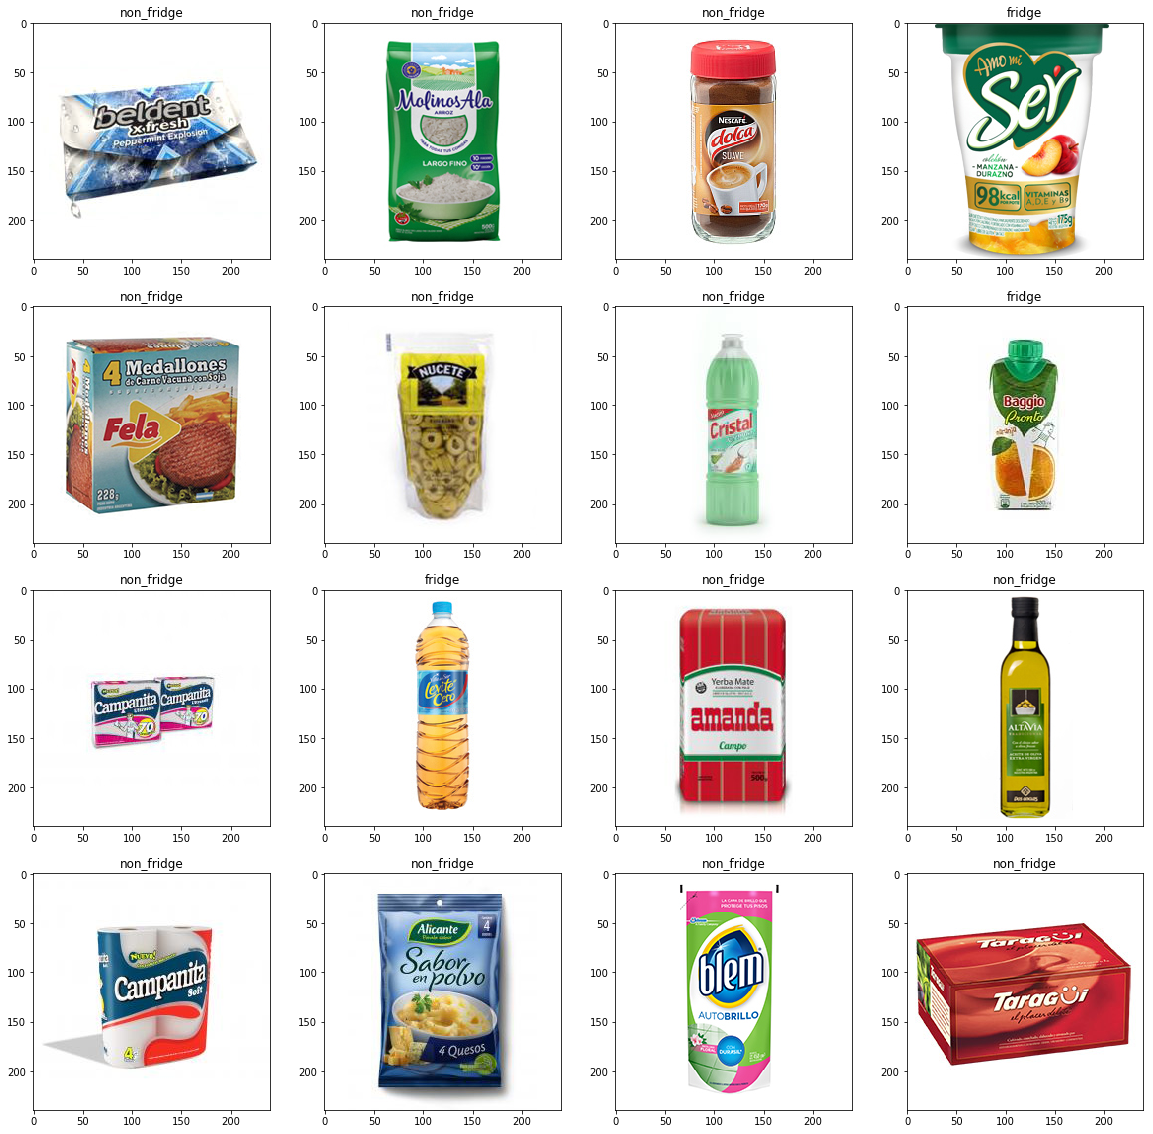

In [4]:
# Dataset images sampling
fig=plt.figure(figsize=(20, 20))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    raw_img_idx = randint(1,raw_img_qty)
    filename = filenames[raw_img_idx]
    target_class = target_classes[raw_img_idx]
    
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    fig.add_subplot(rows, columns, i)
    plt.title(target_names[target_class])
    plt.imshow(img)
plt.show()


# 2. Dataset preparation

### Spliting the dataset

First, I will define which percentage of the data will be destinated to train, validation, and test.

In [5]:
train_pct = 0.75
val_pct = 0.15
test_pct = 0.1

assert(train_pct+val_pct+test_pct==1.0)

Auxiliary methods 

In [14]:
def split_train_val_test(ids, train_pct, val_pct):
    '''
    Splits the ids in train, valid, and test according to the specified percentages.
    
    Input:  ids - set of data indexes
            train_pct - % destinated to the train set
            val_pct - % destinated to the validation set
    
    Output: Tuple (train set, validation set, test set)
            Each component a list of ids
            
    '''
    total = len(ids)

    shuffle(ids)

    train_idx = int(train_pct*total)
    val_idx = int(val_pct*total)


    train_set  = ids[0:train_idx]
    val_set    = ids[train_idx:train_idx+val_idx]
    test_set  = ids[train_idx+val_idx:]
    
    return train_set, val_set, test_set

def merge_sets_and_shuffle(set1, set2):
    '''
    Merges two lists and returns shuffled the result
    '''
    set1 = set1+set2
    shuffle(set1)
    return set1

def get_set_stats(target_set, target_set_fridge, target_set_non_fridge, total):
    '''
    Returns the stats for a set (tuple):
        total
        percentage over all the images
        fridge quantity
        percentage fridge over total
        non-frige qty
        percentage non-fridge over total
    '''
    fridge_qty     = len(target_set_fridge) 
    non_fridge_qty = len(target_set_non_fridge)
    total_set = len(target_set)
    
    pct_total = round(total_set/total,2)
    pct_fridge = round(fridge_qty/total_set,2)
    pct_non_fridge= round(non_fridge_qty/total_set,2)
    
    return total_set, pct_total, fridge_qty, pct_fridge, non_fridge_qty, pct_non_fridge


In [15]:
## The idea is to build the sets keeping the proporsion of each class

# Separates the ids of the images according the class
fridge_ids     = [i for i,p in enumerate(target_classes) if p==0] 
non_fridge_ids = [i for i,p in enumerate(target_classes) if p==1] 


use_equal_parts = True
if use_equal_parts:
    non_fridge_ids = non_fridge_ids[:len(fridge_ids)]        

    
total = len(non_fridge_ids)+len(fridge_ids)

# Divides in sets according the percentage destinated for train, validation, and test set
train_set0, valid_set0, test_set0 = split_train_val_test(fridge_ids,train_pct,val_pct)
train_set1, valid_set1, test_set1 = split_train_val_test(non_fridge_ids,train_pct,val_pct)

# Merges both classes train, valid, and test sets to build a unique train, test, and valid set
train_set_ids = merge_sets_and_shuffle(train_set0, train_set1) 
valid_set_ids = merge_sets_and_shuffle(valid_set0, valid_set1) 
test_set_ids  = merge_sets_and_shuffle(test_set0, test_set1) 

# Priting some stats to see the results
print("Resultant sets stats:")


st = get_set_stats(train_set_ids, train_set0, train_set1, total)
print("Train Set: Total={} ({}%) , Fridge={} ({}%), Non-Frige={} ({}%)".format(*st))

st = get_set_stats(valid_set_ids, valid_set0, valid_set1, total)
print("Valid Set:  Total={} ({}%) , Fridge={} ({}%), Non-Frige={} ({}%)".format(*st))

st = get_set_stats(test_set_ids, test_set0, test_set1, total)
print("Test Set: Total={} ({}%) , Fridge={} ({}%), Non-Frige={} ({}%)".format(*st))


Resultant sets stats:
Train Set: Total=1024 (0.75%) , Fridge=512 (0.5%), Non-Frige=512 (0.5%)
Valid Set:  Total=204 (0.15%) , Fridge=102 (0.5%), Non-Frige=102 (0.5%)
Test Set: Total=138 (0.1%) , Fridge=69 (0.5%), Non-Frige=69 (0.5%)


### Loading the images and labels (without data augmentation in memory)

In [16]:
tgt_image_size = (224,224,3)

def load_images_from_files(ids):
    img_shape = img_to_array(load_img(filenames[0])).shape
    images = np.ndarray(shape=(len(ids),)+tgt_image_size,dtype=float)
    labels = np.ndarray(shape=(len(ids),))
    
    for i, img_nbr in enumerate(ids):
        img = load_img(filenames[img_nbr])  
        img = img.resize(tgt_image_size[:2])
        x = img_to_array(img)  
        
        images[i] = x
        labels[i] = target_classes[img_nbr]
    
    labels = to_categorical(labels, len(target_names))
    return images,labels
        


In [17]:
reload = True

if reload:
    pre_X_train,pre_y_train = load_images_from_files(train_set_ids)
    pre_X_valid,pre_y_valid  = load_images_from_files(valid_set_ids)
    pre_X_test,pre_y_test  = load_images_from_files(test_set_ids)

    


print("-- Pre processed Train dataset --")
print("Dataset shape: ", pre_X_train.shape)
print("Labels shape:", pre_y_train.shape)

print("-- Pre processed Test dataset --")
print("Dataset shape: ", pre_X_valid.shape)
print("Labels shape:", pre_y_valid.shape)

print("-- Pre processed Validate  dataset --")
print("Dataset shape: ", pre_X_test.shape)
print("Labels shape:", pre_y_test.shape)



-- Pre processed Train dataset --
Dataset shape:  (1024, 224, 224, 3)
Labels shape: (1024, 2)
-- Pre processed Test dataset --
Dataset shape:  (204, 224, 224, 3)
Labels shape: (204, 2)
-- Pre processed Validate  dataset --
Dataset shape:  (138, 224, 224, 3)
Labels shape: (138, 2)


### Define the data transformation to be applied (Data Augmentation)

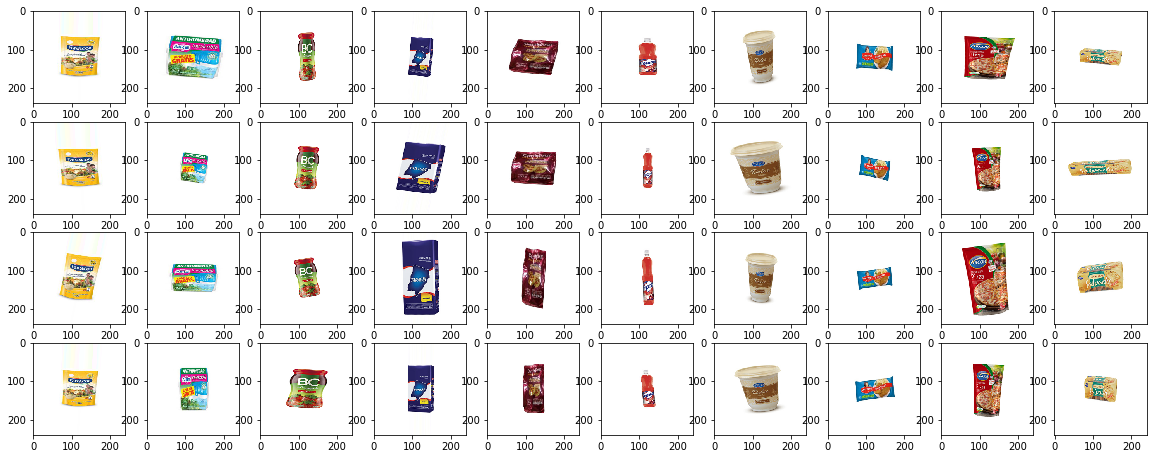

In [18]:
import PIL.Image
from keras.applications.vgg19 import preprocess_input
datagen = ImageDataGenerator(
        rotation_range=10,
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        shear_range=0.5,
        zoom_range=[1,2.5],
        rescale=1./255,
        #preprocessing_function=preprocess_input,
        #horizontal_flip=True,
        fill_mode='nearest')

e = np.ndarray(shape=(10,240,240,3))
j = 0
for i in test_set_ids[1:11]:
    img = load_img(filenames[i])  
    x = img_to_array(img)  
    e[j] = x
    j=j+1

fig=plt.figure(figsize=(20, 20))
columns = 10
rows = 10

j = 0
for batch in datagen.flow(e, batch_size=1, shuffle=False):
    j += 1
    if j > 40:
        break 
        
    xi = array_to_img(batch[0])
    fig.add_subplot(rows, columns, j)

    plt.imshow(xi)
        
        
plt.show()   
    

### The data generators creation (Data Augmentation)

In [19]:
train_datagen = datagen 

valid_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_datagen.fit(pre_X_train)
valid_datagen.fit(pre_X_valid)
test_datagen.fit(pre_X_test)

## 3. Model Building: Benchmark Model 

### Modeling imports

In [20]:
from keras.layers import  Dense, GlobalAveragePooling2D, Flatten, Dropout, Conv2D,MaxPooling2D
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD,Adamax,Adagrad
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
from math import ceil


### Bottleneck features extraction : data preprocessing

In [21]:
def extract_features(datagen, pre_trained_model_type, X, y, batch_size, aug_images_nbr, filename):
    generator = datagen.flow(X, y, batch_size=batch_size, shuffle=False)

    model = pre_trained_model_type(input_shape=X.shape[1:],include_top=False)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
    bottleneck_features = model.predict_generator(generator,  steps=aug_images_nbr*len(X)//batch_size, max_queue_size=10, workers=1, use_multiprocessing=True, verbose=1)
    print("Bottleneck features shape: ",bottleneck_features.shape)
    np.save(filename, bottleneck_features)
    

In [22]:
def generate_bottleneck_features(model_type, batch_size=32, data_augmented_images=8):
    model_name = model_type.__name__
    print("Generating features for model "+model_name)
    extract_features(train_datagen, model_type, pre_X_train, pre_y_train,batch_size, data_augmented_images,model_name+"_train.npy")
    extract_features(valid_datagen, model_type, pre_X_valid, pre_y_valid,batch_size, data_augmented_images,model_name+"_valid.npy")
    extract_features(test_datagen, model_type, pre_X_test, pre_y_test,batch_size, 1,model_name+"_test.npy")
 
#generate_bottleneck_features(VGG19)
#generate_bottleneck_features(VGG16)
generate_bottleneck_features(ResNet50)
#generate_bottleneck_features(Xception,data_augmented_images=4)
#generate_bottleneck_features(InceptionV3)




Generating features for model ResNet50
256/256 [==============================] - 62s 242ms/step
Bottleneck features shape:  (8192, 1, 1, 2048)
51/51 [==============================] - 9s 178ms/step
Bottleneck features shape:  (1492, 1, 1, 2048)
4/4 [==============================] - 2s 410ms/step
Bottleneck features shape:  (128, 1, 1, 2048)


### Benchmark Model 

In [24]:
def load_bottleneck(filename,pre_y):
    X = np.load(filename)
    
    labels_length = len(pre_y)
    X_length = len(X)
    
    times = ceil(X_length / labels_length)
    
    y = np.tile(pre_y, (times,1))[:X_length]
    
    return X,y

def load_bottleneck_class(model_type):
    model_name = model_type.__name__
    X_train, y_train = load_bottleneck(model_name+"_train.npy",pre_y_train)
    X_valid, y_valid = load_bottleneck(model_name+"_valid.npy",pre_y_train)
    X_test, y_test = load_bottleneck(model_name+"_test.npy",pre_y_train)
    
    return  X_train, y_train, X_valid, y_valid, X_test, y_test

X_train, y_train, X_valid, y_valid, X_test, y_test = load_bottleneck_class(ResNet50)    
    
    

In [25]:
bench_model = Sequential()
bench_model.add(GlobalAveragePooling2D(input_shape=X_train.shape[1:]))
bench_model.add(Dense(2, activation='softmax'))
bench_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 4,098
Trainable params: 4,098
Non-trainable params: 0
_________________________________________________________________


In [27]:
def train_benchmark(filename):

    epochs = 200
    batch_size = 64


    sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
    #adamax = Adamax(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    bench_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

    
    checkpoint = ModelCheckpoint(filename, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]

    
    bench_model.fit(X_train, y_train,
              epochs=epochs,
              batch_size=batch_size, validation_data=(X_valid, y_valid), callbacks=callbacks_list)

def train_benchmark_model(model_type, load_bottleneck=True):
    if load_bottleneck:
        load_bottleneck_class(model_type)
        
    model_name = model_type.__name__
    train_benchmark(model_name+".weights.best.hdf5")
        
train_benchmark_model(ResNet50)

Train on 8192 samples, validate on 1492 samples
Epoch 1/200
8192/8192 [==============================] - 1s 132us/step - loss: 0.6893 - acc: 0.5444 - val_loss: 0.6944 - val_acc: 0.5161

Epoch 00001: val_acc improved from -inf to 0.51609, saving model to ResNet50.weights.best.hdf5
Epoch 2/200
8192/8192 [==============================] - 0s 28us/step - loss: 0.6849 - acc: 0.5427 - val_loss: 0.7292 - val_acc: 0.5027

Epoch 00002: val_acc did not improve
Epoch 3/200
8192/8192 [==============================] - 0s 28us/step - loss: 0.6837 - acc: 0.5469 - val_loss: 0.7029 - val_acc: 0.5268

Epoch 00003: val_acc improved from 0.51609 to 0.52681, saving model to ResNet50.weights.best.hdf5
Epoch 4/200
8192/8192 [==============================] - 0s 28us/step - loss: 0.6825 - acc: 0.5474 - val_loss: 0.7022 - val_acc: 0.5235

Epoch 00004: val_acc did not improve
Epoch 5/200
8192/8192 [==============================] - 0s 28us/step - loss: 0.6788 - acc: 0.5573 - val_loss: 0.7025 - val_acc: 0.5147


8192/8192 [==============================] - 0s 32us/step - loss: 0.6546 - acc: 0.6078 - val_loss: 0.7323 - val_acc: 0.5228

Epoch 00044: val_acc did not improve
Epoch 45/200
8192/8192 [==============================] - 0s 27us/step - loss: 0.6526 - acc: 0.6105 - val_loss: 0.7514 - val_acc: 0.5395

Epoch 00045: val_acc did not improve
Epoch 46/200
8192/8192 [==============================] - 0s 32us/step - loss: 0.6531 - acc: 0.6042 - val_loss: 0.7309 - val_acc: 0.5241

Epoch 00046: val_acc did not improve
Epoch 47/200
8192/8192 [==============================] - 0s 29us/step - loss: 0.6528 - acc: 0.6022 - val_loss: 0.7602 - val_acc: 0.5322

Epoch 00047: val_acc did not improve
Epoch 48/200
8192/8192 [==============================] - 0s 31us/step - loss: 0.6514 - acc: 0.6140 - val_loss: 0.7521 - val_acc: 0.5409

Epoch 00048: val_acc did not improve
Epoch 49/200
8192/8192 [==============================] - 0s 29us/step - loss: 0.6526 - acc: 0.6003 - val_loss: 0.7374 - val_acc: 0.5315



8192/8192 [==============================] - 0s 28us/step - loss: 0.6395 - acc: 0.6281 - val_loss: 0.7535 - val_acc: 0.5127

Epoch 00090: val_acc did not improve
Epoch 91/200
8192/8192 [==============================] - 0s 31us/step - loss: 0.6392 - acc: 0.6312 - val_loss: 0.7559 - val_acc: 0.5322

Epoch 00091: val_acc did not improve
Epoch 92/200
8192/8192 [==============================] - 0s 29us/step - loss: 0.6400 - acc: 0.6310 - val_loss: 0.7558 - val_acc: 0.5302

Epoch 00092: val_acc did not improve
Epoch 93/200
8192/8192 [==============================] - 0s 30us/step - loss: 0.6386 - acc: 0.6300 - val_loss: 0.7524 - val_acc: 0.5194

Epoch 00093: val_acc did not improve
Epoch 94/200
8192/8192 [==============================] - 0s 31us/step - loss: 0.6384 - acc: 0.6310 - val_loss: 0.7745 - val_acc: 0.5442

Epoch 00094: val_acc did not improve
Epoch 95/200
8192/8192 [==============================] - 0s 29us/step - loss: 0.6381 - acc: 0.6289 - val_loss: 0.7529 - val_acc: 0.5228




Epoch 00136: val_acc did not improve
Epoch 137/200
8192/8192 [==============================] - 0s 27us/step - loss: 0.6285 - acc: 0.6472 - val_loss: 0.7904 - val_acc: 0.5402

Epoch 00137: val_acc did not improve
Epoch 138/200
8192/8192 [==============================] - 0s 31us/step - loss: 0.6298 - acc: 0.6400 - val_loss: 0.7742 - val_acc: 0.5288

Epoch 00138: val_acc did not improve
Epoch 139/200
8192/8192 [==============================] - 0s 29us/step - loss: 0.6293 - acc: 0.6377 - val_loss: 0.7830 - val_acc: 0.5302

Epoch 00139: val_acc did not improve
Epoch 140/200
8192/8192 [==============================] - 0s 29us/step - loss: 0.6284 - acc: 0.6426 - val_loss: 0.7716 - val_acc: 0.5255

Epoch 00140: val_acc did not improve
Epoch 141/200
8192/8192 [==============================] - 0s 31us/step - loss: 0.6274 - acc: 0.6429 - val_loss: 0.7788 - val_acc: 0.5094

Epoch 00141: val_acc did not improve
Epoch 142/200
8192/8192 [==============================] - 0s 30us/step - loss: 0.

8192/8192 [==============================] - 0s 31us/step - loss: 0.6206 - acc: 0.6542 - val_loss: 0.8613 - val_acc: 0.5188

Epoch 00183: val_acc did not improve
Epoch 184/200
8192/8192 [==============================] - 0s 28us/step - loss: 0.6204 - acc: 0.6522 - val_loss: 0.8014 - val_acc: 0.5375

Epoch 00184: val_acc did not improve
Epoch 185/200
8192/8192 [==============================] - 0s 31us/step - loss: 0.6200 - acc: 0.6504 - val_loss: 0.7985 - val_acc: 0.5322

Epoch 00185: val_acc did not improve
Epoch 186/200
8192/8192 [==============================] - 0s 28us/step - loss: 0.6195 - acc: 0.6514 - val_loss: 0.7895 - val_acc: 0.5261

Epoch 00186: val_acc did not improve
Epoch 187/200
8192/8192 [==============================] - 0s 29us/step - loss: 0.6224 - acc: 0.6459 - val_loss: 0.7893 - val_acc: 0.5268

Epoch 00187: val_acc did not improve
Epoch 188/200
8192/8192 [==============================] - 0s 31us/step - loss: 0.6192 - acc: 0.6549 - val_loss: 0.8270 - val_acc: 0.5

## 4. Model Building: Product detector from the scratch

### Preparing Data Generators for Data Augmentation

In [28]:
batch_size = 128
train_generator = train_datagen.flow(pre_X_train, pre_y_train, batch_size=batch_size, shuffle=False)
valid_generator = valid_datagen.flow(pre_X_valid, pre_y_valid, batch_size=batch_size, shuffle=False)
test_generator = test_datagen.flow(pre_X_test, pre_y_test, batch_size=batch_size, shuffle=False)



### Defining the model

In [35]:

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=2, strides=1, activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Conv2D(filters=32, kernel_size=2, strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Conv2D(filters=64, kernel_size=2, strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Conv2D(filters=128, kernel_size=2, strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 54, 54, 64)        8256      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 27, 27, 64)        0         
_________________________________________________________________
dense_5 (Dense)              (None, 27, 27, 64)        4160      
__________

### Training the model

In [37]:
train_model = True
epochs = 3200
val_epochs=800
batch_size = 64

#sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
adamax = Adamax(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adamax, metrics=['accuracy'])

if train_model:
    filepath="model_weights.best.hdf5"
    
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    model.fit_generator(
            train_generator,
            steps_per_epoch=epochs // batch_size,
            epochs=epochs,
            callbacks=callbacks_list,
            validation_data=valid_generator,
            validation_steps=800 // batch_size)

Epoch 1/3200
50/50 [==============================] - 44s 879ms/step - loss: 0.6940 - acc: 0.5103 - val_loss: 0.6924 - val_acc: 0.5000

Epoch 00001: val_acc improved from -inf to 0.50000, saving model to model_weights.best.hdf5
Epoch 2/3200
50/50 [==============================] - 42s 840ms/step - loss: 0.6926 - acc: 0.5089 - val_loss: 0.6914 - val_acc: 0.5147

Epoch 00002: val_acc improved from 0.50000 to 0.51471, saving model to model_weights.best.hdf5
Epoch 3/3200
50/50 [==============================] - 43s 859ms/step - loss: 0.6919 - acc: 0.5192 - val_loss: 0.6909 - val_acc: 0.5000

Epoch 00003: val_acc did not improve
Epoch 4/3200
50/50 [==============================] - 43s 859ms/step - loss: 0.6908 - acc: 0.5361 - val_loss: 0.6898 - val_acc: 0.5490

Epoch 00004: val_acc improved from 0.51471 to 0.54902, saving model to model_weights.best.hdf5
Epoch 5/3200
50/50 [==============================] - 44s 871ms/step - loss: 0.6892 - acc: 0.5398 - val_loss: 0.6890 - val_acc: 0.5637

E

50/50 [==============================] - 43s 861ms/step - loss: 0.5681 - acc: 0.7083 - val_loss: 0.5975 - val_acc: 0.6912

Epoch 00044: val_acc did not improve
Epoch 45/3200
50/50 [==============================] - 43s 860ms/step - loss: 0.5688 - acc: 0.7037 - val_loss: 0.5938 - val_acc: 0.7059

Epoch 00045: val_acc did not improve
Epoch 46/3200
50/50 [==============================] - 43s 855ms/step - loss: 0.5656 - acc: 0.7069 - val_loss: 0.5936 - val_acc: 0.7157

Epoch 00046: val_acc did not improve
Epoch 47/3200
50/50 [==============================] - 43s 861ms/step - loss: 0.5613 - acc: 0.7025 - val_loss: 0.5908 - val_acc: 0.7010

Epoch 00047: val_acc did not improve
Epoch 48/3200
50/50 [==============================] - 43s 856ms/step - loss: 0.5595 - acc: 0.7083 - val_loss: 0.5975 - val_acc: 0.6961

Epoch 00048: val_acc did not improve
Epoch 49/3200
50/50 [==============================] - 43s 863ms/step - loss: 0.5571 - acc: 0.7095 - val_loss: 0.5914 - val_acc: 0.7010

Epoch 0

50/50 [==============================] - 43s 863ms/step - loss: 0.4858 - acc: 0.7606 - val_loss: 0.5846 - val_acc: 0.7255

Epoch 00090: val_acc did not improve
Epoch 91/3200
50/50 [==============================] - 43s 860ms/step - loss: 0.4846 - acc: 0.7691 - val_loss: 0.5993 - val_acc: 0.7353

Epoch 00091: val_acc did not improve
Epoch 92/3200
50/50 [==============================] - 43s 862ms/step - loss: 0.4722 - acc: 0.7762 - val_loss: 0.5929 - val_acc: 0.7304

Epoch 00092: val_acc did not improve
Epoch 93/3200
50/50 [==============================] - 43s 862ms/step - loss: 0.4729 - acc: 0.7664 - val_loss: 0.6123 - val_acc: 0.7206

Epoch 00093: val_acc did not improve
Epoch 94/3200
50/50 [==============================] - 43s 860ms/step - loss: 0.4723 - acc: 0.7736 - val_loss: 0.6139 - val_acc: 0.7255

Epoch 00094: val_acc did not improve
Epoch 95/3200
50/50 [==============================] - 43s 860ms/step - loss: 0.4684 - acc: 0.7742 - val_loss: 0.6032 - val_acc: 0.7255

Epoch 0

50/50 [==============================] - 43s 863ms/step - loss: 0.4060 - acc: 0.8128 - val_loss: 0.5927 - val_acc: 0.7402

Epoch 00136: val_acc did not improve
Epoch 137/3200
50/50 [==============================] - 43s 861ms/step - loss: 0.4111 - acc: 0.8097 - val_loss: 0.5884 - val_acc: 0.7353

Epoch 00137: val_acc did not improve
Epoch 138/3200
50/50 [==============================] - 43s 860ms/step - loss: 0.4123 - acc: 0.8059 - val_loss: 0.6059 - val_acc: 0.7304

Epoch 00138: val_acc did not improve
Epoch 139/3200
50/50 [==============================] - 43s 858ms/step - loss: 0.4046 - acc: 0.8050 - val_loss: 0.5900 - val_acc: 0.7353

Epoch 00139: val_acc did not improve
Epoch 140/3200
50/50 [==============================] - 43s 862ms/step - loss: 0.4063 - acc: 0.8142 - val_loss: 0.6079 - val_acc: 0.7255

Epoch 00140: val_acc did not improve
Epoch 141/3200
50/50 [==============================] - 43s 853ms/step - loss: 0.4091 - acc: 0.8095 - val_loss: 0.5819 - val_acc: 0.7255

Ep

50/50 [==============================] - 43s 860ms/step - loss: 0.3487 - acc: 0.8403 - val_loss: 0.6462 - val_acc: 0.7255

Epoch 00183: val_acc did not improve
Epoch 184/3200
50/50 [==============================] - 43s 863ms/step - loss: 0.3460 - acc: 0.8416 - val_loss: 0.6431 - val_acc: 0.7304

Epoch 00184: val_acc did not improve
Epoch 185/3200
50/50 [==============================] - 43s 859ms/step - loss: 0.3493 - acc: 0.8389 - val_loss: 0.6314 - val_acc: 0.7402

Epoch 00185: val_acc did not improve
Epoch 186/3200
50/50 [==============================] - 43s 861ms/step - loss: 0.3447 - acc: 0.8456 - val_loss: 0.6315 - val_acc: 0.7402

Epoch 00186: val_acc did not improve
Epoch 187/3200
50/50 [==============================] - 43s 862ms/step - loss: 0.3510 - acc: 0.8400 - val_loss: 0.5828 - val_acc: 0.7157

Epoch 00187: val_acc did not improve
Epoch 188/3200
50/50 [==============================] - 43s 861ms/step - loss: 0.3409 - acc: 0.8495 - val_loss: 0.6435 - val_acc: 0.7304

Ep

KeyboardInterrupt: 

## 5. Predictions Stats

### Bechmark Testing and Stats

In [48]:
model_type = ResNet50
model_name = model_type.__name__

bench_model.load_weights(model_name+".weights.best.hdf5")
print("Loaded model from disk")
 
score = bench_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (bench_model.metrics_names[1], score[1]*100))



Loaded model from disk
acc: 51.56%


(128, 2)


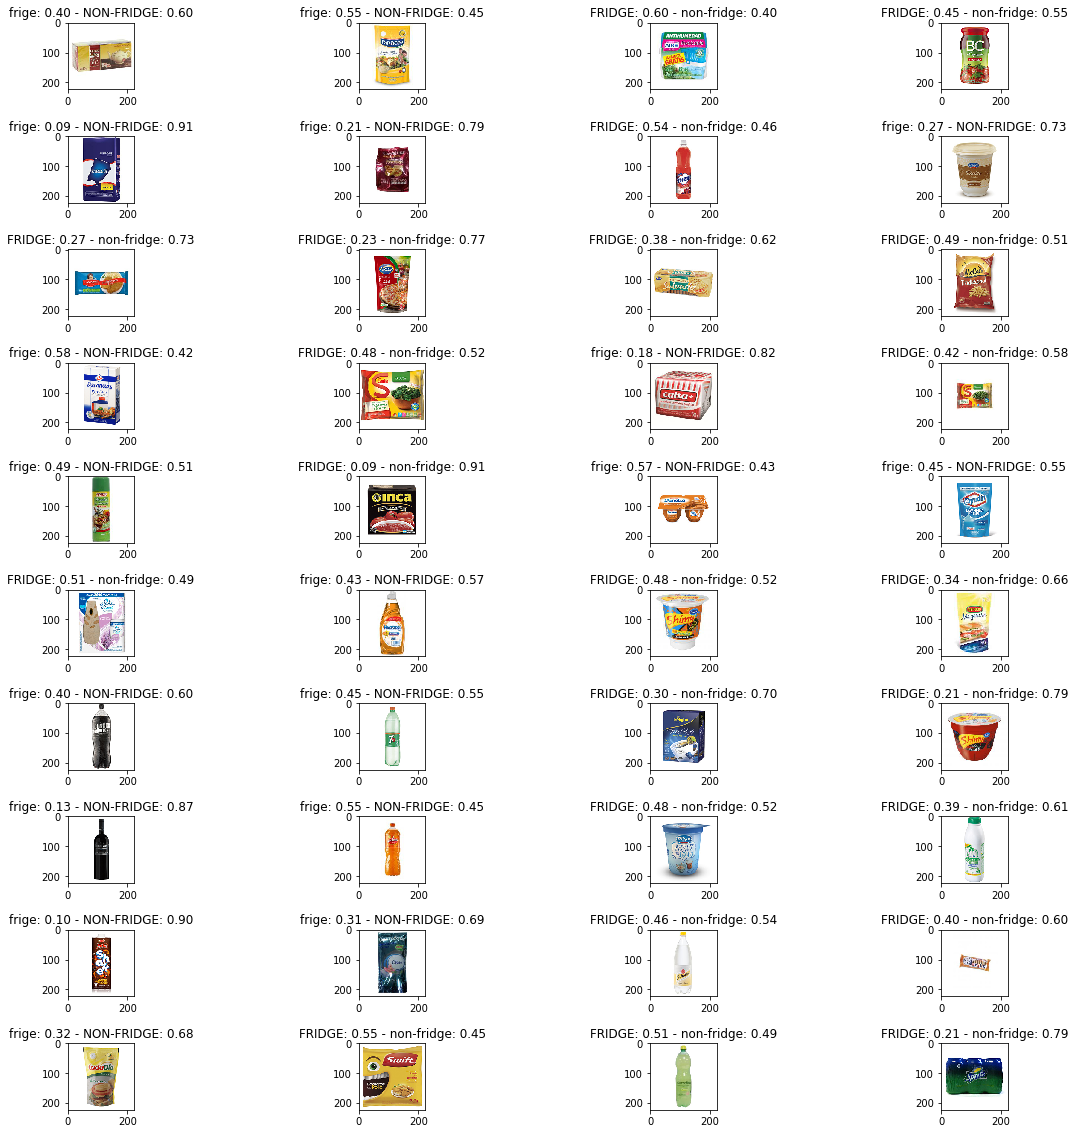

In [42]:
prediction = bench_model.predict(X_test)
print(prediction.shape)

columns = 4
rows = 10
fig=plt.figure(figsize=(20, 20))

for i,pred in enumerate(prediction[0:40]):
    fig.add_subplot(rows, columns, i+1)
    plt.subplots_adjust( hspace=0.70)
    
    xi = array_to_img(pre_X_test[i])
    plt.imshow(xi)
    if y_test[i][0] == 1:
        plt.title("FRIDGE: {:1.2f} - non-fridge: {:1.2f}".format(pred[0],pred[1]))
    else:
        plt.title("frige: {:1.2f} - NON-FRIDGE: {:1.2f}".format(pred[0],pred[1]))
   
    

### Model Testing and Stats

In [49]:
model.load_weights("model_weights.best.hdf5")
print("Loaded model from disk")
 
score = model.evaluate_generator(test_generator)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))


Loaded model from disk
acc: 71.01%


(138, 2)


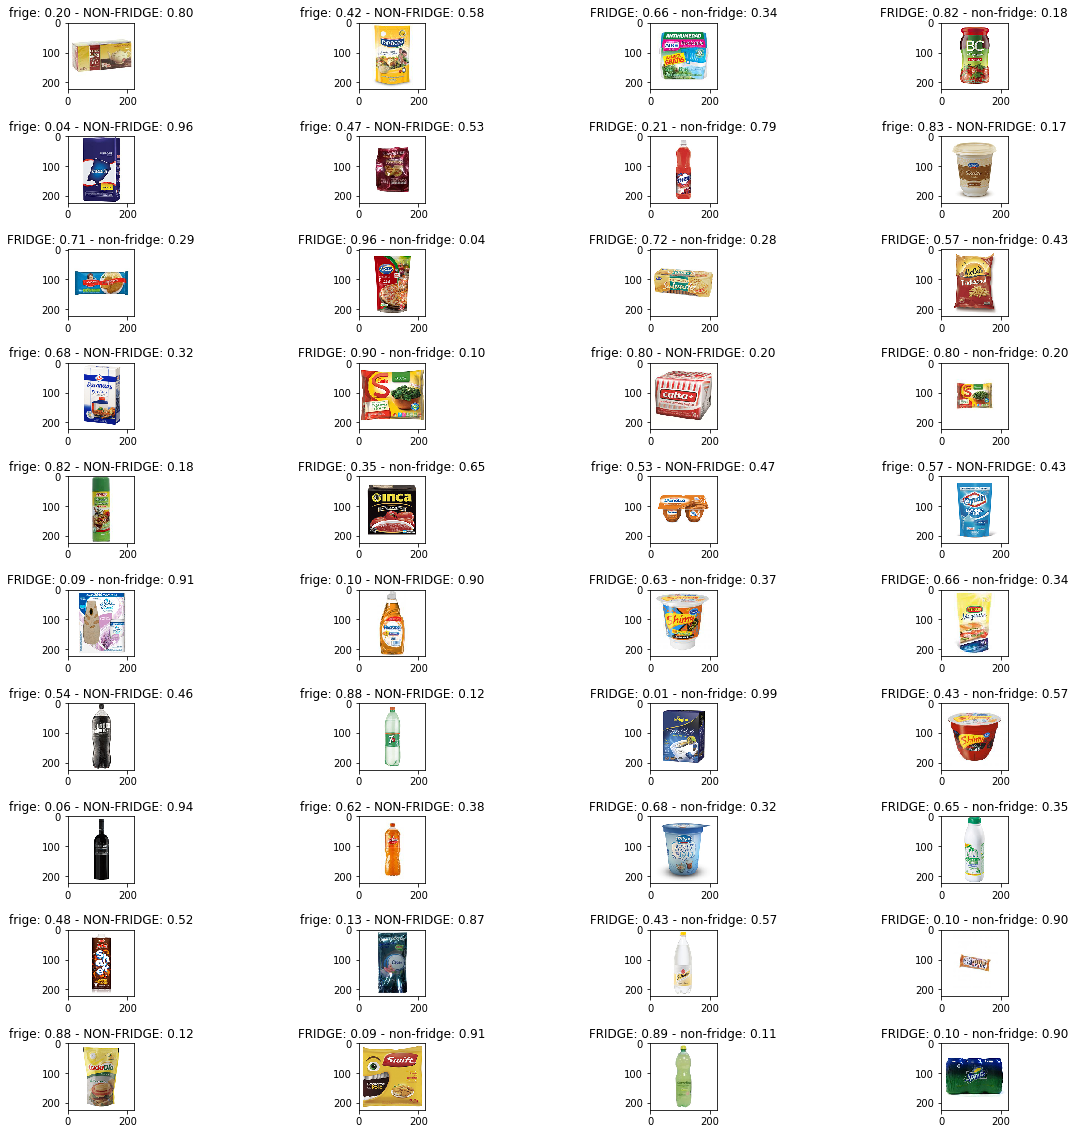

In [50]:
prediction = model.predict_generator(test_generator)
print(prediction.shape)

columns = 4
rows = 10
fig=plt.figure(figsize=(20, 20))

for i,pred in enumerate(prediction[0:40]):
    fig.add_subplot(rows, columns, i+1)
    plt.subplots_adjust( hspace=0.70)
    
    xi = array_to_img(pre_X_test[i])
    plt.imshow(xi)
    if y_test[i][0] == 1:
        plt.title("FRIDGE: {:1.2f} - non-fridge: {:1.2f}".format(pred[0],pred[1]))
    else:
        plt.title("frige: {:1.2f} - NON-FRIDGE: {:1.2f}".format(pred[0],pred[1]))
   
    